In [1]:
# Step 1: Install required libraries (if needed)
!pip install -q pandas matplotlib seaborn

# Step 2: Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import files

# Upload both CSVs
uploaded = files.upload()


Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv


In [3]:
import pandas as pd

# Load datasets
trader_df = pd.read_csv('historical_data.csv')  # Or use uploaded name
sentiment_df = pd.read_csv('fear_greed_index.csv')

# Convert date columns
trader_df['Date'] = pd.to_datetime(trader_df['Timestamp IST'], format='%d-%m-%Y %H:%M').dt.date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date

# Merge trader data with sentiment on date
merged_df = pd.merge(trader_df, sentiment_df[['date', 'classification']], left_on='Date', right_on='date', how='left')

# Drop rows without sentiment info
merged_df.dropna(subset=['classification'], inplace=True)

# Show sample
merged_df[['Account', 'Coin', 'Closed PnL', 'Date', 'classification']].head()


,Account,Coin,Closed PnL,Date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,2024-12-02,Extreme Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,2024-12-02,Extreme Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,2024-12-02,Extreme Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,2024-12-02,Extreme Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,0.0,2024-12-02,Extreme Greed


In [38]:
merged_df.to_csv("merged_data.csv", index=False)


In [39]:
# Feature 1: Was the trade profitable?
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0

# Feature 2: Normalized PnL = PnL / Size USD
merged_df['norm_pnl'] = merged_df['Closed PnL'] / (merged_df['Size USD'] + 1e-6)  # Avoid division by zero

# Feature 3: Fee as percentage of trade size
merged_df['fee_pct'] = merged_df['Fee'] / (merged_df['Size USD'] + 1e-6)

# Feature 4: Simplify sentiment into 2 categories
def simplify_sentiment(label):
    if 'fear' in label.lower():
        return 'Fear'
    elif 'greed' in label.lower():
        return 'Greed'
    else:
        return 'Neutral'

merged_df['classification_grouped'] = merged_df['classification'].apply(simplify_sentiment)

# View new features
merged_df[['Closed PnL', 'norm_pnl', 'is_profitable', 'fee_pct', 'classification', 'classification_grouped']].head()


,Closed PnL,norm_pnl,is_profitable,fee_pct,classification,classification_grouped
0,0.0,0.0,False,0.000044,Extreme Greed,Greed
1,0.0,0.0,False,0.000044,Extreme Greed,Greed
2,0.0,0.0,False,0.000044,Extreme Greed,Greed
3,0.0,0.0,False,0.000044,Extreme Greed,Greed
4,0.0,0.0,False,0.000044,Extreme Greed,Greed


In [40]:
# Group by sentiment and calculate key stats
summary = merged_df.groupby('classification_grouped').agg({
    'is_profitable': 'mean',
    'norm_pnl': ['mean', 'median'],
    'Closed PnL': ['mean', 'median'],
    'fee_pct': 'mean'
}).round(4)

# Rename columns for clarity
summary.columns = [
    'Profit Rate',
    'Avg Normalized PnL',
    'Median Normalized PnL',
    'Avg Closed PnL',
    'Median Closed PnL',
    'Avg Fee %'
]

summary.reset_index(inplace=True)
summary


,classification_grouped,Profit Rate,Avg Normalized PnL,Median Normalized PnL,Avg Closed PnL,Median Closed PnL,Avg Fee %
0,Fear,0.4079,0.0126,0.0,49.2121,0.0,0.0004
1,Greed,0.4203,0.0287,0.0,53.8823,0.0,0.0003
2,Neutral,0.3970,0.0099,0.0,34.3077,0.0,0.0004


/tmp/ipython-input-41-2581520453.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='classification_grouped', y='Profit Rate', palette='viridis')
/tmp/ipython-input-41-2581520453.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=summary, x='classification_grouped', y='Avg Normalized PnL', palette='mako')
/tmp/ipython-input-41-2581520453.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df, x='classification_grouped', y='Closed PnL', palette='coolwarm')


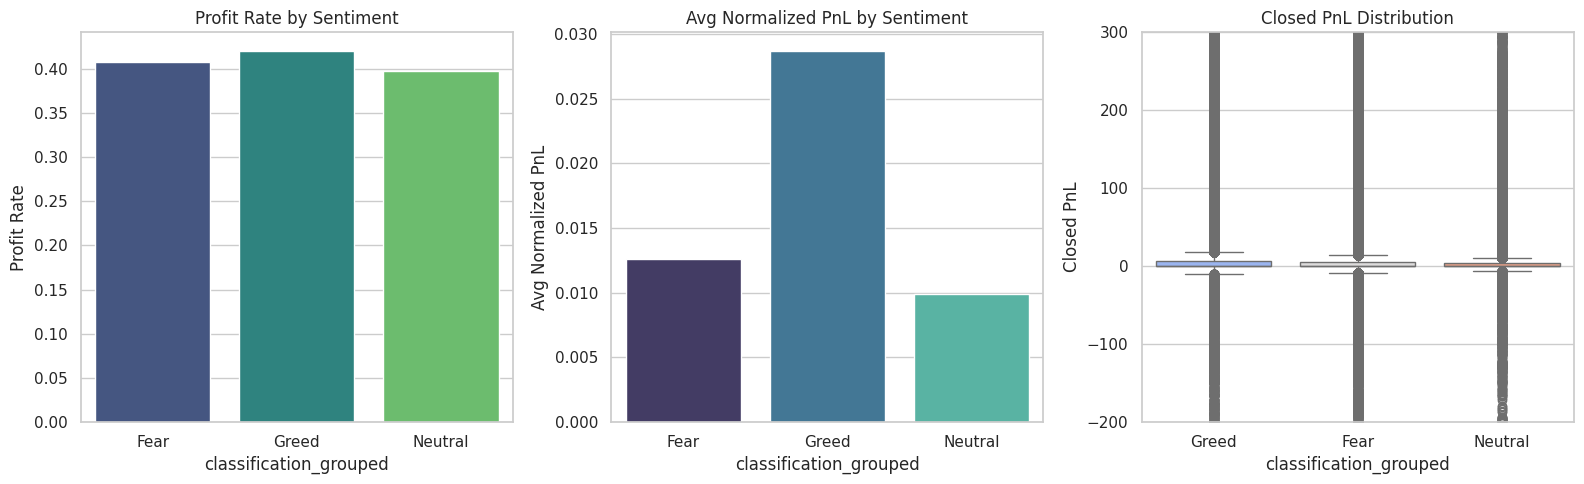

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(16, 5))

# --- 1. Profit Rate ---
plt.subplot(1, 3, 1)
sns.barplot(data=summary, x='classification_grouped', y='Profit Rate', palette='viridis')
plt.title('Profit Rate by Sentiment')

# --- 2. Normalized PnL ---
plt.subplot(1, 3, 2)
sns.barplot(data=summary, x='classification_grouped', y='Avg Normalized PnL', palette='mako')
plt.title('Avg Normalized PnL by Sentiment')

# --- 3. Boxplot of Closed PnL ---
plt.subplot(1, 3, 3)
sns.boxplot(data=merged_df, x='classification_grouped', y='Closed PnL', palette='coolwarm')
plt.ylim(-200, 300)  # Limit to focus on main range
plt.title('Closed PnL Distribution')

plt.tight_layout()
plt.show()


📊 Average Position Size by Sentiment


,classification_grouped,Avg Position Size (USD)
0,Fear,7182.011019
1,Greed,4574.424490
2,Neutral,4782.732661


/tmp/ipython-input-42-2535154557.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=size_stats, x='classification_grouped', y='Avg Position Size (USD)', palette='coolwarm')


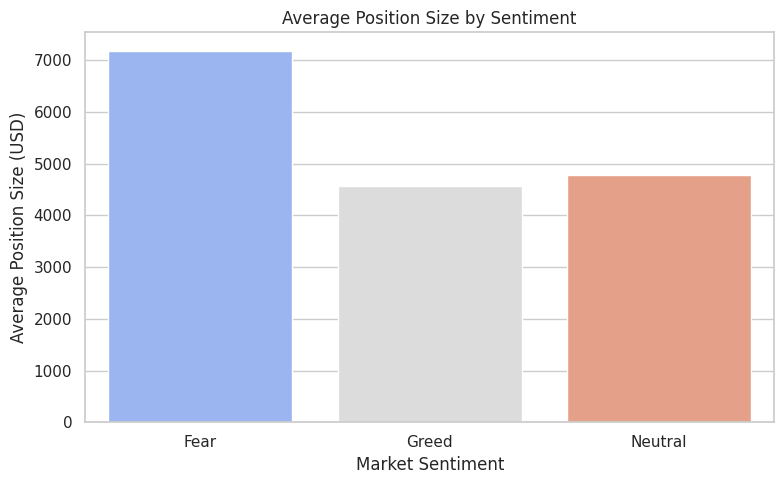

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate average absolute position size (in USD) per sentiment group
merged_df['abs_size'] = merged_df['Size USD'].abs()
size_stats = merged_df.groupby('classification_grouped')['abs_size'].mean().reset_index()
size_stats.rename(columns={'abs_size': 'Avg Position Size (USD)'}, inplace=True)

# Show table
print("📊 Average Position Size by Sentiment")
display(size_stats)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=size_stats, x='classification_grouped', y='Avg Position Size (USD)', palette='coolwarm')
plt.title('Average Position Size by Sentiment')
plt.ylabel('Average Position Size (USD)')
plt.xlabel('Market Sentiment')
plt.tight_layout()
plt.show()


📊 Top vs Bottom Traders' Avg PnL by Sentiment


,classification_grouped,Top Traders PnL,Bottom Traders PnL
0,Fear,65.471845,9.321637
1,Greed,110.054824,-15.777928
2,Neutral,53.831636,8.778206


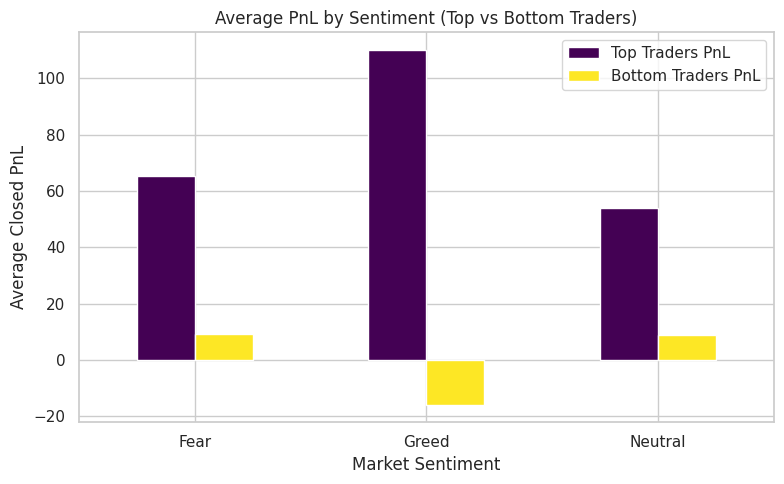

In [43]:
# Step 1: Account-level total PnL
account_perf = merged_df.groupby(['Account', 'classification_grouped'])['Closed PnL'].sum().reset_index()

# Step 2: Identify top 10 and bottom 10 performers overall
top_accounts = merged_df.groupby('Account')['Closed PnL'].sum().sort_values(ascending=False).head(10).index
bottom_accounts = merged_df.groupby('Account')['Closed PnL'].sum().sort_values().head(10).index

# Step 3: Filter top/bottom
top_df = merged_df[merged_df['Account'].isin(top_accounts)]
bottom_df = merged_df[merged_df['Account'].isin(bottom_accounts)]

# Group by sentiment
top_stats = top_df.groupby('classification_grouped')['Closed PnL'].mean().reset_index().rename(columns={'Closed PnL': 'Top Traders PnL'})
bottom_stats = bottom_df.groupby('classification_grouped')['Closed PnL'].mean().reset_index().rename(columns={'Closed PnL': 'Bottom Traders PnL'})

# Merge both
combined_stats = pd.merge(top_stats, bottom_stats, on='classification_grouped')

# Show table
print("📊 Top vs Bottom Traders' Avg PnL by Sentiment")
display(combined_stats)

# Plot
combined_stats.set_index('classification_grouped').plot(kind='bar', figsize=(8, 5), colormap='viridis')
plt.title('Average PnL by Sentiment (Top vs Bottom Traders)')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


📊 PnL-to-Fee Ratio by Sentiment


,classification_grouped,PnL to Fee Ratio
0,Fear,118141.811878
1,Greed,211569.597121
2,Neutral,80790.156856


/tmp/ipython-input-44-3199989303.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=efficiency_df, x='classification_grouped', y='PnL to Fee Ratio', palette='magma')


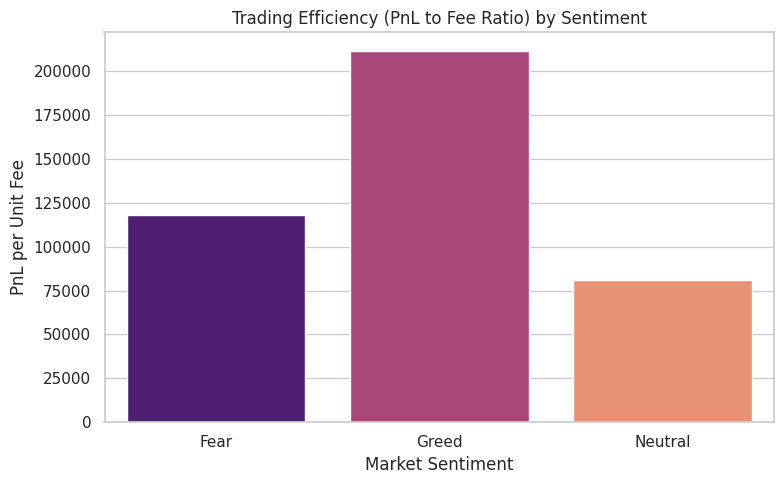

In [44]:
# Calculate efficiency = Avg PnL / Avg Fee per sentiment
efficiency_df = merged_df.groupby('classification_grouped').agg({
    'Closed PnL': 'mean',
    'fee_pct': 'mean'
}).reset_index()

efficiency_df['PnL to Fee Ratio'] = efficiency_df['Closed PnL'] / efficiency_df['fee_pct']

# Show table
print("📊 PnL-to-Fee Ratio by Sentiment")
display(efficiency_df[['classification_grouped', 'PnL to Fee Ratio']])

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=efficiency_df, x='classification_grouped', y='PnL to Fee Ratio', palette='magma')
plt.title('Trading Efficiency (PnL to Fee Ratio) by Sentiment')
plt.ylabel('PnL per Unit Fee')
plt.xlabel('Market Sentiment')
plt.tight_layout()
plt.show()


📊 Daily Win Rate by Sentiment


,Date,classification_grouped,Win Rate
0,2023-05-01,Greed,0.000000
1,2023-12-05,Greed,0.000000
2,2023-12-14,Greed,36.363636
3,2023-12-15,Greed,0.000000
4,2023-12-16,Greed,0.000000
...,...,...,...
474,2025-04-27,Greed,35.608309
475,2025-04-28,Neutral,41.696882
476,2025-04-29,Greed,43.201070
477,2025-04-30,Greed,26.504942


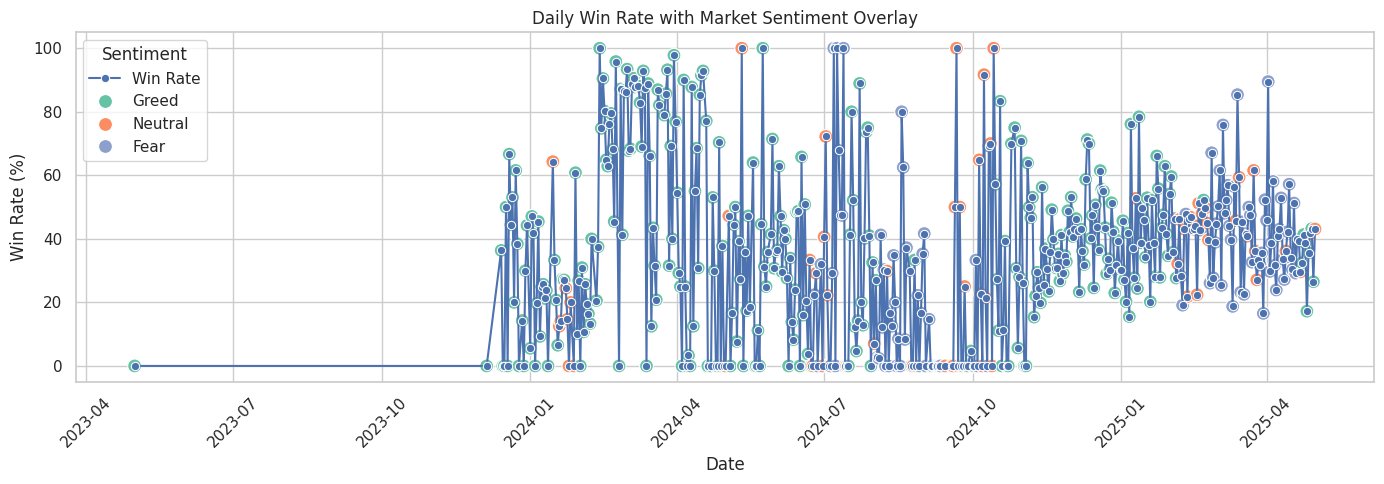

In [45]:
# Prepare daily win rate and sentiment
daily_stats = merged_df.groupby('Date').agg({
    'is_profitable': 'mean',
    'classification_grouped': 'first'  # assuming same sentiment per day
}).reset_index()
daily_stats['Win Rate'] = daily_stats['is_profitable'] * 100

# Show table
print("📊 Daily Win Rate by Sentiment")
display(daily_stats[['Date', 'classification_grouped', 'Win Rate']])

# Plot
plt.figure(figsize=(14, 5))
sns.lineplot(data=daily_stats, x='Date', y='Win Rate', label='Win Rate', marker='o')
sns.scatterplot(data=daily_stats, x='Date', y='Win Rate', hue='classification_grouped', palette='Set2', s=100)
plt.title('Daily Win Rate with Market Sentiment Overlay')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()


📊 Win/Loss Ratio by Sentiment


,classification_grouped,Win/Loss Ratio
0,Fear,0.688823
1,Greed,0.725064
2,Neutral,0.658350


/tmp/ipython-input-46-3741261053.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=win_loss, x='classification_grouped', y='Win/Loss Ratio', palette='Set1')


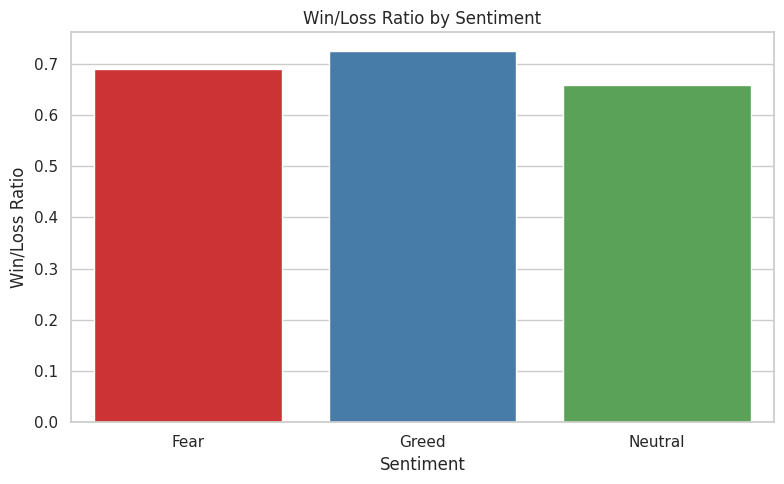

In [46]:
# Count wins and losses per sentiment
win_loss = merged_df.groupby('classification_grouped')['is_profitable'].agg(['sum', 'count']).reset_index()
win_loss['Win/Loss Ratio'] = win_loss['sum'] / (win_loss['count'] - win_loss['sum'])

# Show table
print("📊 Win/Loss Ratio by Sentiment")
display(win_loss[['classification_grouped', 'Win/Loss Ratio']])

# Plot
plt.figure(figsize=(8,5))
sns.barplot(data=win_loss, x='classification_grouped', y='Win/Loss Ratio', palette='Set1')
plt.title('Win/Loss Ratio by Sentiment')
plt.ylabel('Win/Loss Ratio')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()


📊 Max Drawdown by Sentiment


,classification_grouped,Max Drawdown
0,Fear,-165878.958367
1,Greed,-479910.332872
2,Neutral,-132639.360699


/tmp/ipython-input-48-2922854072.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=drawdown_df, x='classification_grouped', y='Max Drawdown', palette='Blues')


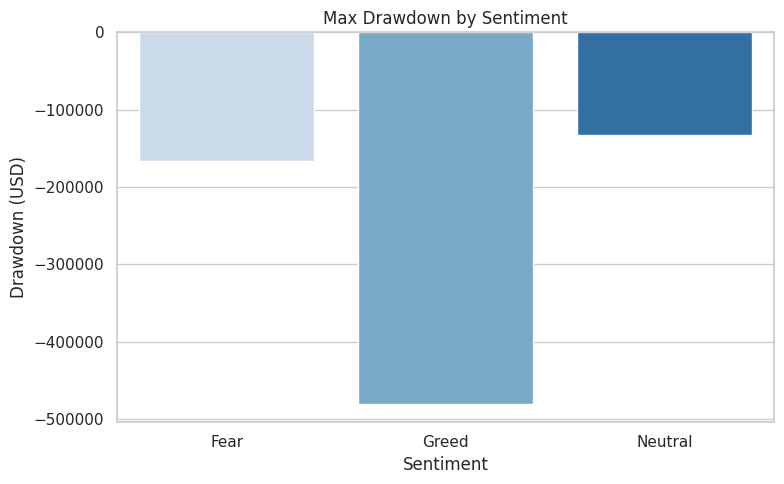

In [48]:
# Create cumulative PnL per sentiment
merged_df['cum_pnl'] = merged_df.groupby('classification_grouped')['Closed PnL'].cumsum()

# Calculate rolling max and drawdown
merged_df['rolling_max'] = merged_df.groupby('classification_grouped')['cum_pnl'].transform('cummax')
merged_df['drawdown'] = merged_df['cum_pnl'] - merged_df['rolling_max']

# Show table
drawdown_df = merged_df.groupby('classification_grouped')['drawdown'].min().reset_index()
drawdown_df.rename(columns={'drawdown': 'Max Drawdown'}, inplace=True)
print("📊 Max Drawdown by Sentiment")
display(drawdown_df)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=drawdown_df, x='classification_grouped', y='Max Drawdown', palette='Blues')
plt.title('Max Drawdown by Sentiment')
plt.ylabel('Drawdown (USD)')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()


📊 Volume Stats by Sentiment


,classification_grouped,Avg Volume,Max Volume
0,Fear,7182.011019,3921430.72
1,Greed,4574.424490,2227114.71
2,Neutral,4782.732661,3641180.84


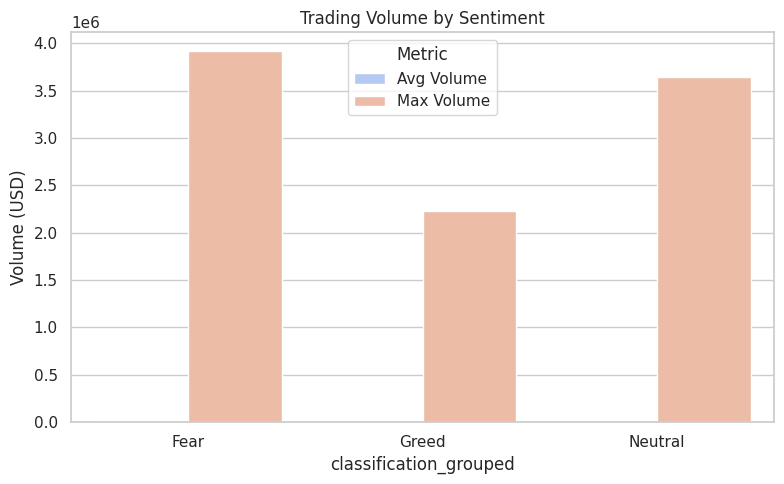

In [49]:
volume_stats = merged_df.groupby('classification_grouped')['Size USD'].agg(['mean', 'max']).reset_index()
volume_stats.rename(columns={'mean': 'Avg Volume', 'max': 'Max Volume'}, inplace=True)

print("📊 Volume Stats by Sentiment")
display(volume_stats)

# Plot
volume_stats_melted = volume_stats.melt(id_vars='classification_grouped', var_name='Metric', value_name='Volume')

plt.figure(figsize=(8, 5))
sns.barplot(data=volume_stats_melted, x='classification_grouped', y='Volume', hue='Metric', palette='coolwarm')
plt.title('Trading Volume by Sentiment')
plt.ylabel('Volume (USD)')
plt.tight_layout()
plt.show()


In [50]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load your merged data
df = pd.read_csv("merged_data.csv")

# Preprocessing
df = df.copy()
df = df.dropna(subset=["classification_grouped", "Side"])
df["Side"] = df["Side"].map({"Buy": 1, "Sell": 0})

# Features & Target
features = ["Size USD", "fee_pct", "Closed PnL", "norm_pnl", "Side"]
X = df[features]
y = df["classification_grouped"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print("📊 Classification Report:\n")
print(classification_report(y_test, y_pred))


📊 Classification Report:

              precision    recall  f1-score   support

        Fear       0.70      0.71      0.70     20809
       Greed       0.71      0.75      0.73     22574
     Neutral       0.56      0.48      0.52      9422

    accuracy                           0.69     52805
   macro avg       0.66      0.65      0.65     52805
weighted avg       0.68      0.69      0.68     52805



In [51]:
# Add a win/loss column
df["win"] = df["Closed PnL"] > 0

# Group by sentiment
win_loss_stats = df.groupby("classification_grouped")["win"].agg([
    ("Total Trades", "count"),
    ("Wins", "sum"),
    ("Losses", lambda x: (~x).sum()),
    ("Win Rate (%)", lambda x: round(100 * x.sum() / len(x), 2))
]).reset_index()

print("📊 Win/Loss Breakdown by Sentiment:")
print(win_loss_stats)


📊 Win/Loss Breakdown by Sentiment:
  classification_grouped  Total Trades   Wins  Losses  Win Rate (%)
0                   Fear         83237  33950   49287         40.79
1                  Greed         90295  37952   52343         42.03
2                Neutral         37686  14961   22725         39.70


In [52]:
#test
sample = pd.DataFrame([{
    "Size USD": 12000,
    "fee_pct": 0.4,
    "Closed PnL": 320,
    "norm_pnl": 0.025,
    "Side": 1  # Buy
}])

predicted_sentiment = clf.predict(sample)[0]
print(f"🔮 Predicted Sentiment: {predicted_sentiment}")


🔮 Predicted Sentiment: Greed


**FINAL**

In [54]:
import pandas as pd

# Load final merged dataset
df = pd.read_csv("merged_data.csv")

# Basic preprocessing
df['Side'] = df['Side'].map({'Buy': 1, 'Sell': 0})
df = df.dropna(subset=['classification_grouped'])

# Features and target
features = ['Size USD', 'fee_pct', 'Closed PnL', 'norm_pnl', 'Side']
X = df[features]
y = df['classification_grouped']


In [55]:
!pip install xgboost scikit-learn matplotlib seaborn


**MODEL COMPARISON**


🔍 Random Forest Performance:
Accuracy: 0.9942
F1 Score: 0.9942
Classification Report:
               precision    recall  f1-score   support

 Extreme Fear       0.99      0.99      0.99      5350
Extreme Greed       0.99      0.99      0.99      9998
         Fear       0.99      1.00      1.00     15459
        Greed       0.99      0.99      0.99     12576
      Neutral       1.00      1.00      1.00      9422

     accuracy                           0.99     52805
    macro avg       0.99      0.99      0.99     52805
 weighted avg       0.99      0.99      0.99     52805



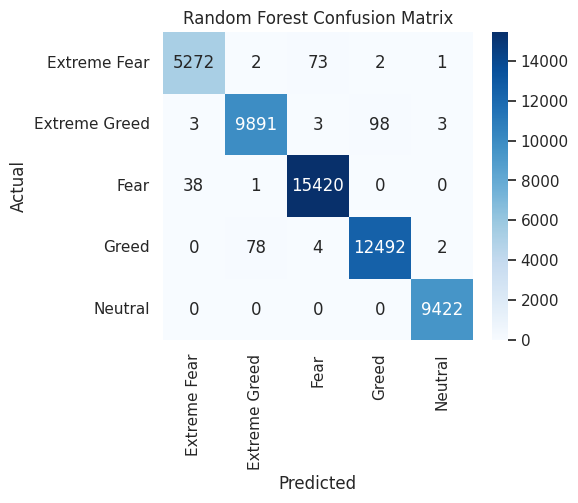


🔍 XGBoost Performance:


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [13:53:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.9761
F1 Score: 0.9761
Classification Report:
               precision    recall  f1-score   support

 Extreme Fear       0.98      0.95      0.97      5350
Extreme Greed       0.96      0.95      0.96      9998
         Fear       0.98      0.99      0.99     15459
        Greed       0.96      0.97      0.97     12576
      Neutral       1.00      1.00      1.00      9422

     accuracy                           0.98     52805
    macro avg       0.98      0.97      0.97     52805
 weighted avg       0.98      0.98      0.98     52805



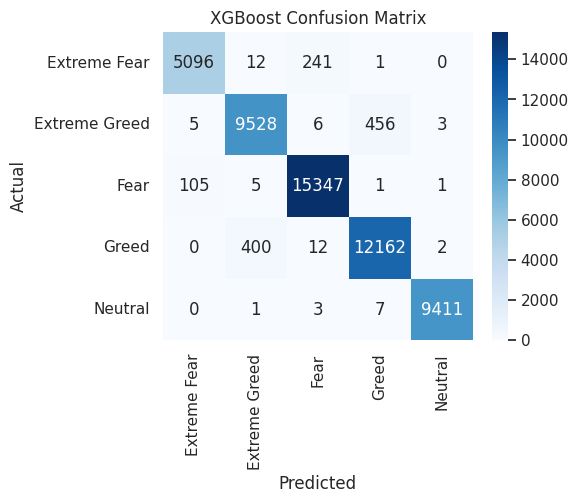


🔍 MLP (Neural Net) Performance:
Accuracy: 0.3030
F1 Score: 0.1534
Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

 Extreme Fear       0.00      0.00      0.00      5350
Extreme Greed       0.00      0.00      0.00      9998
         Fear       0.30      1.00      0.46     15459
        Greed       1.00      0.04      0.08     12576
      Neutral       1.00      0.00      0.00      9422

     accuracy                           0.30     52805
    macro avg       0.46      0.21      0.11     52805
 weighted avg       0.50      0.30      0.15     52805



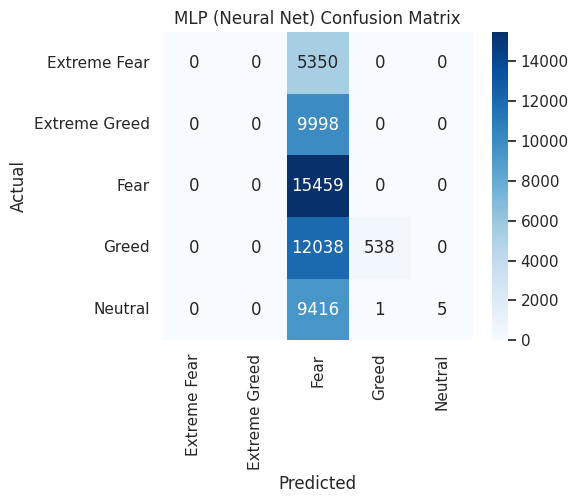

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Choose your target
target = 'classification'  # or 'is_profitable'

# Define proper feature list based on your actual DataFrame
features = [
    'Execution Price',
    'Size Tokens',
    'Size USD',
    'Fee',
    'fee_pct',
    'abs_size',
    'cum_pnl',
    'rolling_max',
    'drawdown'
]

# Drop rows with missing target or features
data = merged_df[features + [target]].dropna(subset=[target])
X = data[features]
y = data[target]

# Split and fill
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

# Encode y if it's categorical (e.g. classification)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "MLP (Neural Net)": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"\n🔍 {name} Performance:")
    model.fit(X_train, y_train_enc)
    y_pred_enc = model.predict(X_test)
    y_pred = le.inverse_transform(y_pred_enc)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred, labels=le.classes_)

    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Save results
    results[name] = {'model': model, 'accuracy': acc, 'f1': f1, 'confusion_matrix': cm}

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



🔢 Model Performance Comparison Table:
              Model  Accuracy  F1 Score
0     Random Forest  0.994167  0.994164
1           XGBoost  0.976120  0.976085
2  MLP (Neural Net)  0.303039  0.153388


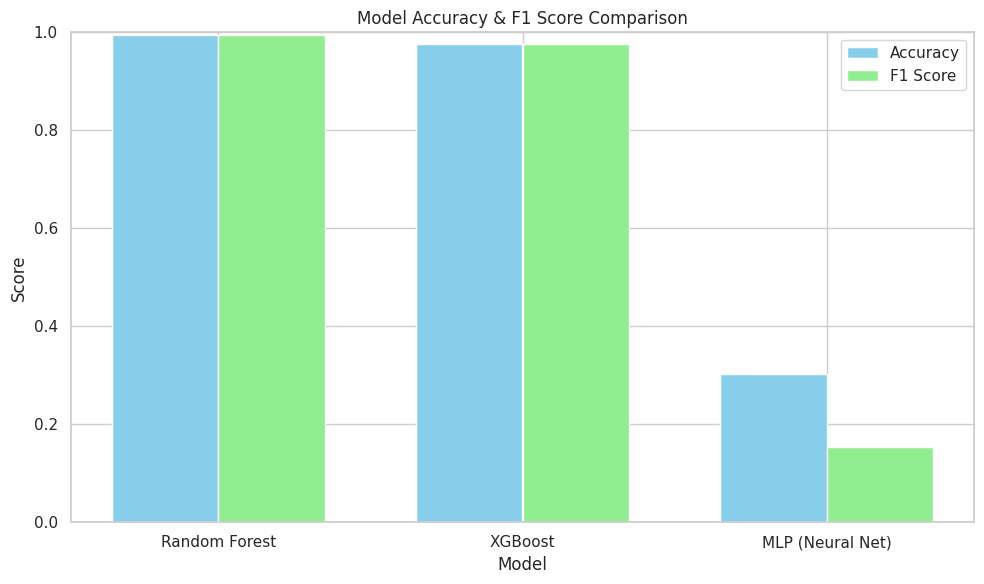

In [63]:
import pandas as pd

# Create DataFrame from results
comparison_df = pd.DataFrame({
    "Model": list(results.keys()),
    "Accuracy": [results[m]["accuracy"] for m in results],
    "F1 Score": [results[m]["f1"] for m in results]
}).sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

# 📊 Display table
print("\n🔢 Model Performance Comparison Table:")
print(comparison_df)

# 📈 Bar Plot for Accuracy & F1 Score
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(comparison_df))

plt.bar(index, comparison_df["Accuracy"], bar_width, label="Accuracy", color='skyblue')
plt.bar([i + bar_width for i in index], comparison_df["F1 Score"], bar_width, label="F1 Score", color='lightgreen')

plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Accuracy & F1 Score Comparison")
plt.xticks([i + bar_width / 2 for i in index], comparison_df["Model"])
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


In [64]:
!pip install shap


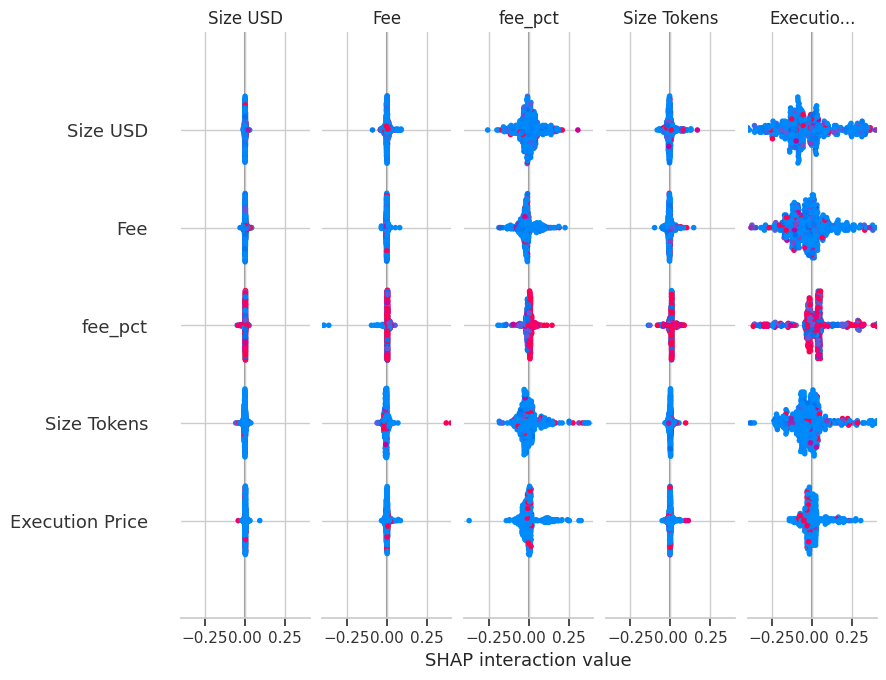

In [66]:
import shap

# Pick the best model
best_model_name = "Random Forest"
best_model = results[best_model_name]["model"]

# Use TreeExplainer for tree-based models
explainer = shap.TreeExplainer(best_model)

# Use a small sample of the test set for speed
X_sample = X_test.sample(500, random_state=42)

# Get SHAP values
shap_values = explainer.shap_values(X_sample)

shap.summary_plot(shap_values, X_sample, feature_names=features, class_names=le.classes_)


In [67]:
import joblib

# Save the model
joblib.dump(best_model, "random_forest_model.pkl")

# Save the label encoder
joblib.dump(le, "label_encoder.pkl")

# Save feature list (in case needed for consistent input later)
import json
with open("feature_list.json", "w") as f:
    json.dump(features, f)

print("✅ Model, LabelEncoder, and Feature list saved!")


✅ Model, LabelEncoder, and Feature list saved!
